In [1]:
# 1) Upload kaggle.json
from google.colab import files
files.upload()  # pilih file kaggle.json dari komputer Anda

# 2) Pindahkan & set permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle


Saving kaggle.json to kaggle.json
total 4
-rw------- 1 root root 64 Aug 21 12:03 kaggle.json


In [2]:
!mkdir -p data/olist
!kaggle datasets download -d olistbr/brazilian-ecommerce -p data/olist
!unzip -q data/olist/brazilian-ecommerce.zip -d data/olist

Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 1.34GB/s]


In [3]:
import pandas as pd
import os

# Folder tempat file CSV diekstrak
folder_path = "data/olist"

# List semua file CSV
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Simpan semua DataFrame dalam dictionary
olist_data = {}

for file in csv_files:
    df_name = file.replace(".csv", "")  # nama DataFrame tanpa ekstensi
    df_path = os.path.join(folder_path, file)
    df = pd.read_csv(df_path)
    olist_data[df_name] = df
    print(f"{df_name}: {df.shape}")

# Contoh akses salah satu DataFrame
print("\nContoh isi dari olist_orders_dataset:")
print(olist_data['olist_orders_dataset'].head())


olist_order_payments_dataset: (103886, 5)
olist_geolocation_dataset: (1000163, 5)
olist_orders_dataset: (99441, 8)
olist_products_dataset: (32951, 9)
olist_customers_dataset: (99441, 5)
product_category_name_translation: (71, 2)
olist_order_reviews_dataset: (99224, 7)
olist_order_items_dataset: (112650, 7)
olist_sellers_dataset: (3095, 4)

Contoh isi dari olist_orders_dataset:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 0

In [4]:
!pip install graphviz
from graphviz import Digraph

dot = Digraph(comment='Olist Dataset Relationships', format='png')

# Tambahkan node
tables = [
    "olist_customers_dataset",
    "olist_orders_dataset",
    "olist_order_items_dataset",
    "olist_products_dataset",
    "olist_sellers_dataset",
    "olist_order_payments_dataset",
    "olist_order_reviews_dataset",
    "product_category_name_translation",
    "olist_geolocation_dataset"
]
for table in tables:
    dot.node(table, table)

# Relasi
dot.edge("olist_customers_dataset", "olist_orders_dataset", label="customer_id")
dot.edge("olist_orders_dataset", "olist_order_items_dataset", label="order_id")
dot.edge("olist_orders_dataset", "olist_order_payments_dataset", label="order_id")
dot.edge("olist_orders_dataset", "olist_order_reviews_dataset", label="order_id")
dot.edge("olist_order_items_dataset", "olist_products_dataset", label="product_id")
dot.edge("olist_order_items_dataset", "olist_sellers_dataset", label="seller_id")
dot.edge("olist_products_dataset", "product_category_name_translation", label="product_category_name")
dot.edge("olist_geolocation_dataset", "olist_customers_dataset", label="zip_code_prefix")
dot.edge("olist_geolocation_dataset", "olist_sellers_dataset", label="zip_code_prefix")

# Simpan & tampilkan
dot.render("olist_relationships", view=True)


'olist_relationships.png'

In [5]:
import pandas as pd
import numpy as np
import os
from collections import Counter

folder_path = "data/olist"

# --- Helper ---
def read_csv(name):
    path = os.path.join(folder_path, name)
    assert os.path.exists(path), f"File tidak ditemukan: {path}"
    return pd.read_csv(path, low_memory=False)

# 1) Load tables
orders      = read_csv("olist_orders_dataset.csv")
customers   = read_csv("olist_customers_dataset.csv")
order_items = read_csv("olist_order_items_dataset.csv")
payments    = read_csv("olist_order_payments_dataset.csv")
reviews     = read_csv("olist_order_reviews_dataset.csv")
products    = read_csv("olist_products_dataset.csv")
cat_tr      = read_csv("product_category_name_translation.csv")

# 2) Datetime parsing
for c in [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date",
    "order_estimated_delivery_date"
]:
    orders[c] = pd.to_datetime(orders[c], errors="coerce")
reviews["review_creation_date"]   = pd.to_datetime(reviews["review_creation_date"], errors="coerce")
reviews["review_answer_timestamp"] = pd.to_datetime(reviews["review_answer_timestamp"], errors="coerce")
order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"], errors="coerce")

# 3) Product category (pakai terjemahan Inggris kalau ada)
products = products.merge(cat_tr, how="left", on="product_category_name", suffixes=("", "_en"))
products["product_category"] = products["product_category_name_english"].fillna(products["product_category_name"])

# 4) Aggregate order_items (+ join product info dulu)
items_prod = order_items.merge(
    products[["product_id", "product_category", "product_weight_g", "product_photos_qty"]],
    on="product_id", how="left"
)

agg_items = items_prod.groupby("order_id").agg(
    n_items       = ("order_item_id", "count"),
    n_sellers     = ("seller_id", pd.Series.nunique),
    n_products    = ("product_id", pd.Series.nunique),
    total_price   = ("price", "sum"),
    total_freight = ("freight_value", "sum"),
    total_weight_g= ("product_weight_g", "sum"),
    total_photos  = ("product_photos_qty", "sum"),
    first_shipping_limit = ("shipping_limit_date", "min"),
)

def mode_category(s):
    s = s.dropna().tolist()
    return Counter(s).most_common(1)[0][0] if s else np.nan

top_cat = items_prod.groupby("order_id")["product_category"].apply(mode_category).rename("main_product_category")
agg_items = agg_items.merge(top_cat, left_index=True, right_index=True, how="left")

# 5) Aggregate payments
pay_agg = payments.groupby("order_id").agg(
    total_payment_value=("payment_value", "sum"),
    n_payments=("payment_sequential", "max"),
    max_installments=("payment_installments", "max"),
)

ptype_by_value = payments.groupby(["order_id","payment_type"])["payment_value"].sum().reset_index()
idx = ptype_by_value.groupby("order_id")["payment_value"].idxmax()
main_ptype = ptype_by_value.loc[idx, ["order_id","payment_type"]].set_index("order_id")
pay_agg = pay_agg.merge(main_ptype, left_index=True, right_index=True, how="left").rename(columns={"payment_type":"main_payment_type"})

# 6) Aggregate reviews
rev_agg = reviews.groupby("order_id").agg(
    review_score_mean=("review_score","mean"),
    review_score_median=("review_score","median"),
    review_count=("review_id","count"),
    first_review_date=("review_creation_date","min"),
)

# 7) Base orders + customers
base = orders.merge(
    customers[["customer_id","customer_unique_id","customer_zip_code_prefix","customer_city","customer_state"]],
    on="customer_id", how="left"
)

# 8) Feature engineering waktu & keterlambatan
def days_between(a, b):
    return (a - b).dt.total_seconds() / (60*60*24)

base["delivery_time_days"]    = days_between(base["order_delivered_customer_date"], base["order_purchase_timestamp"])
base["approval_time_hours"]   = (base["order_approved_at"] - base["order_purchase_timestamp"]).dt.total_seconds() / 3600
base["carrier_handling_hours"]= (base["order_delivered_carrier_date"] - base["order_approved_at"]).dt.total_seconds() / 3600
base["carrier_to_customer_days"] = days_between(base["order_delivered_customer_date"], base["order_delivered_carrier_date"])
base["estimated_delay_days"]  = days_between(base["order_delivered_customer_date"], base["order_estimated_delivery_date"])

# 9) Merge semua agregat
datamart = (base
    .merge(agg_items.reset_index(), on="order_id", how="left")
    .merge(pay_agg.reset_index(), on="order_id", how="left")
    .merge(rev_agg.reset_index(), on="order_id", how="left")
)

# 10) Urutan kolom yang enak
cols_first = [
    "order_id","order_status","order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_city","customer_state","customer_zip_code_prefix",
    "n_items","n_products","n_sellers","main_product_category",
    "total_price","total_freight","total_weight_g","total_photos",
    "total_payment_value","n_payments","max_installments","main_payment_type",
    "review_score_mean","review_score_median","review_count",
    "delivery_time_days","approval_time_hours","carrier_handling_hours","carrier_to_customer_days","estimated_delay_days"
]
cols_first = [c for c in cols_first if c in datamart.columns]
datamart = datamart[cols_first + [c for c in datamart.columns if c not in cols_first]]

# 11) Simpan & preview
out_path = "data/olist_datamart.csv"
datamart.to_csv(out_path, index=False)
print(f"Datamart shape: {datamart.shape[0]:,} rows × {datamart.shape[1]:,} columns")
datamart.head(10)


Datamart shape: 99,441 rows × 34 columns


,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,...,review_score_median,review_count,delivery_time_days,approval_time_hours,carrier_handling_hours,carrier_to_customer_days,estimated_delay_days,customer_id,first_shipping_limit,first_review_date
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,...,4.0,1.0,8.436574,0.178333,56.795833,6.062650,-7.107488,9ef432eb6251297304e76186b10a928d,2017-10-06 11:07:15,2017-10-11
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,barreiras,BA,...,4.0,1.0,13.782037,30.713889,11.109167,12.039410,-5.355729,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-30 03:24:27,2018-08-08
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,...,5.0,1.0,9.394213,0.276111,4.910278,9.178113,-17.245498,41ce2a54c0b03bf3443c3d931a367089,2018-08-13 08:55:23,2018-08-18
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,RN,...,5.0,1.0,13.208750,0.298056,89.900000,9.450498,-12.980069,f88197465ea7920adcdbec7375364d82,2017-11-23 19:45:59,2017-12-03
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP,...,5.0,1.0,2.873877,1.030556,21.434722,1.937824,-9.238171,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-19 20:31:37,2018-02-17
5,a4591c265e18cb1dcee52889e2d8acc3,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,congonhinhas,PR,...,4.0,1.0,16.542245,0.218889,40.797500,14.833229,-5.543113,503740e9ca751ccdda7ba28e9ab8f608,2017-07-13 22:10:13,2017-07-27
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,santa rosa,RS,...,2.0,1.0,NaN,49.052500,NaN,NaN,NaN,ed0271e0b7da060a393796590e7b737a,2017-04-19 13:25:17,2017-05-13
7,6514b8ad8028c9f2cc2374ded245783f,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,nilopolis,RJ,...,5.0,1.0,9.989826,0.194722,140.759722,4.116725,-11.461215,9bdf08b4b3b52b5526ff42d37d47f222,2017-05-22 13:22:11,2017-05-27
8,76c6e866289321a7c93b82b54852dc33,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,faxinalzinho,RS,...,1.0,1.0,9.818762,32.360556,35.428889,6.994201,-31.410995,f54a9f0e6b351c431402b8461ea51999,2017-01-27 18:29:09,2017-02-03
9,e69bfb5eb88e0ed6a785585b27e16dbf,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,299905e3934e9e181bfb2e164dd4b4f8,sorocaba,SP,...,5.0,1.0,18.221852,0.175000,295.664444,5.895208,-6.281597,31ad1d1b63eb9962463f764d4e6e0c9d,2017-08-11 12:05:32,2017-08-17


In [6]:
# 11) Handling NaN dan NaT

# Untuk kolom tanggal, ganti NaT dengan None (biar aman saat export)
for col in datamart.select_dtypes(include=["datetime64[ns]"]).columns:
    datamart[col] = datamart[col].astype("string")

# Untuk kolom numeric, isi NaN dengan 0
for col in datamart.select_dtypes(include=[np.number]).columns:
    datamart[col] = datamart[col].fillna(0)

# Untuk kolom object/string, isi NaN dengan 'Unknown'
for col in datamart.select_dtypes(include=["object", "string"]).columns:
    datamart[col] = datamart[col].fillna("Unknown")

# 12) Simpan & preview
out_path = "data/olist_datamart_clean.csv"
datamart.to_csv(out_path, index=False)
print(f"Datamart (clean) shape: {datamart.shape[0]:,} rows × {datamart.shape[1]:,} columns")
datamart.head(10)


Datamart (clean) shape: 99,441 rows × 34 columns


,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,...,review_score_median,review_count,delivery_time_days,approval_time_hours,carrier_handling_hours,carrier_to_customer_days,estimated_delay_days,customer_id,first_shipping_limit,first_review_date
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,...,4.0,1.0,8.436574,0.178333,56.795833,6.062650,-7.107488,9ef432eb6251297304e76186b10a928d,2017-10-06 11:07:15,2017-10-11 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,barreiras,BA,...,4.0,1.0,13.782037,30.713889,11.109167,12.039410,-5.355729,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-30 03:24:27,2018-08-08 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,...,5.0,1.0,9.394213,0.276111,4.910278,9.178113,-17.245498,41ce2a54c0b03bf3443c3d931a367089,2018-08-13 08:55:23,2018-08-18 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,RN,...,5.0,1.0,13.208750,0.298056,89.900000,9.450498,-12.980069,f88197465ea7920adcdbec7375364d82,2017-11-23 19:45:59,2017-12-03 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP,...,5.0,1.0,2.873877,1.030556,21.434722,1.937824,-9.238171,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-19 20:31:37,2018-02-17 00:00:00
5,a4591c265e18cb1dcee52889e2d8acc3,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,congonhinhas,PR,...,4.0,1.0,16.542245,0.218889,40.797500,14.833229,-5.543113,503740e9ca751ccdda7ba28e9ab8f608,2017-07-13 22:10:13,2017-07-27 00:00:00
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,Unknown,Unknown,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,santa rosa,RS,...,2.0,1.0,0.000000,49.052500,0.000000,0.000000,0.000000,ed0271e0b7da060a393796590e7b737a,2017-04-19 13:25:17,2017-05-13 00:00:00
7,6514b8ad8028c9f2cc2374ded245783f,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,nilopolis,RJ,...,5.0,1.0,9.989826,0.194722,140.759722,4.116725,-11.461215,9bdf08b4b3b52b5526ff42d37d47f222,2017-05-22 13:22:11,2017-05-27 00:00:00
8,76c6e866289321a7c93b82b54852dc33,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,faxinalzinho,RS,...,1.0,1.0,9.818762,32.360556,35.428889,6.994201,-31.410995,f54a9f0e6b351c431402b8461ea51999,2017-01-27 18:29:09,2017-02-03 00:00:00
9,e69bfb5eb88e0ed6a785585b27e16dbf,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,299905e3934e9e181bfb2e164dd4b4f8,sorocaba,SP,...,5.0,1.0,18.221852,0.175000,295.664444,5.895208,-6.281597,31ad1d1b63eb9962463f764d4e6e0c9d,2017-08-11 12:05:32,2017-08-17 00:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 28.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
[INFO] SELLER_ID tidak diisi. Menggunakan seller populer periode ini: 6560211a19b47992c3666cc44a7e94c0
[AUTO] VEHICLE_COUNT ditingkatkan:

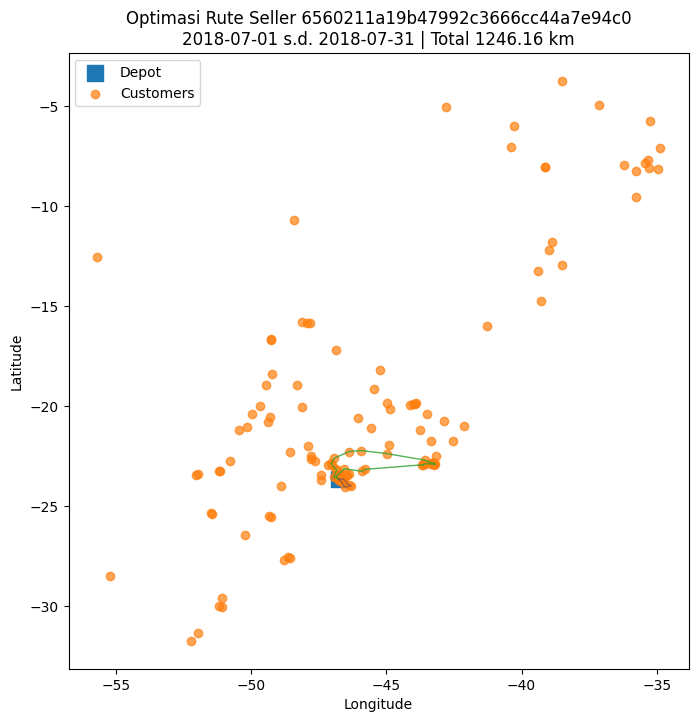


File tersimpan:
- data/route_plan/route_assignments.csv
- data/route_plan/route_summary.csv


In [7]:
# ===============================================================
# CVRP (Capacitated Vehicle Routing Problem) for Olist Deliveries
# ---------------------------------------------------------------
# - Filter order per SELLER_ID + tanggal (delivered)
# - Estimasi koordinat pelanggan & depot via zip_code_prefix (Olist geolocation)
# - Bangun matriks jarak (Haversine)
# - Optimasi rute dengan OR-Tools (kapasitas kendaraan, jumlah kendaraan, max distance opsional)
# - Output: Assignments rute, urutan kunjungan, jarak per rute, total jarak
# - Visualisasi rute (matplotlib)
# ===============================================================

!pip -q install ortools

import pandas as pd
import numpy as np
import os, math
from datetime import datetime
import matplotlib.pyplot as plt

# =======================
# 0) PARAMETER USER
# =======================
DATAMART_PATH = "data/olist_datamart_clean.csv"  # ganti bila beda
GEO_PATH = "data/olist/olist_geolocation_dataset.csv"  # dari dataset Olist asli
SELLER_ID = None  # isi otomatis dari order_items; kalau None, skrip akan pilih seller top pada periode
DATE_FROM = "2018-07-01"
DATE_TO   = "2018-07-31"

VEHICLE_COUNT   = 4    # jumlah kendaraan
VEHICLE_CAPACITY= 30   # kapasitas = jumlah paket per kendaraan
MAX_ROUTE_KM    = None # misal 120.0 untuk batasi panjang rute per kendaraan (opsional)

# =======================
# 1) LOAD DATA
# =======================
datamart = pd.read_csv(DATAMART_PATH, low_memory=False)
geo = pd.read_csv(GEO_PATH, low_memory=False)

# Ambil mapping zip_code_prefix -> (lat, lng) rata-rata
zip_latlng = (geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat","geolocation_lng"]]
                .mean().rename(columns={"geolocation_lat":"lat","geolocation_lng":"lng"}))

# =======================
# 2) AMBIL ORDER UNTUK 1 SELLER
# =======================
# Kita butuh info seller_id per order_id -> ambil dari order_items asli
order_items = pd.read_csv("data/olist/olist_order_items_dataset.csv", low_memory=False)
# Ambil hanya informasi minimal
oi = order_items[["order_id","seller_id"]].drop_duplicates()

# Join datamart (order-level) ke seller (item-level) agar tahu seller per order
df = datamart.merge(oi, on="order_id", how="left")

# Parsing tanggal delivered
for c in ["order_delivered_customer_date"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Filter delivered & date range
mask = (
    (df["order_status"]=="delivered") &
    (df["order_delivered_customer_date"].between(pd.to_datetime(DATE_FROM), pd.to_datetime(DATE_TO)))
)
dfp = df.loc[mask].copy()

if SELLER_ID is None:
    # pilih seller dengan jumlah order terbanyak pada periode ini
    SELLER_ID = dfp["seller_id"].value_counts().index[0]
    print(f"[INFO] SELLER_ID tidak diisi. Menggunakan seller populer periode ini: {SELLER_ID}")

dfp = dfp[dfp["seller_id"]==SELLER_ID].copy()

# Pastikan satu order = satu paket (kalau mau bisa expand by n_items)
dfp["packages"] = 1

# =======================
# 3) BANGUN KOORDINAT DEPOT & PELANGGAN
# =======================
# Estimasi depot: gunakan zip_code_prefix milik seller (ambil top prefix)
sellers = pd.read_csv("data/olist/olist_sellers_dataset.csv", low_memory=False)
seller_row = sellers[sellers["seller_id"]==SELLER_ID]
if seller_row.empty:
    raise ValueError("SELLER_ID tidak ditemukan di sellers dataset.")

seller_zip = seller_row["seller_zip_code_prefix"].mode().iloc[0]
depot_latlng = zip_latlng.loc[seller_zip] if seller_zip in zip_latlng.index else None
if depot_latlng is None or depot_latlng.isna().any():
    # fallback: gunakan mean seluruh latlng customer pada rute
    print("[WARN] Koordinat depot tidak ditemukan dari zip prefix. Pakai centroid pelanggan.")
    # centroid dari pelanggan (akan dihitung di bawah)

# Koordinat pelanggan dari customer_zip_code_prefix
dfp = dfp.merge(zip_latlng, left_on="customer_zip_code_prefix", right_index=True, how="left")

# Drop order tanpa koordinat
dfp = dfp.dropna(subset=["lat","lng"]).reset_index(drop=True)

if dfp.shape[0] < 3:
    raise ValueError("Titik pengantaran < 3 setelah filter. Perlu lebih banyak order untuk optimasi rute.")

# Jika depot kosong, pakai centroid pelanggan
if (depot_latlng is None) or depot_latlng.isna().any():
    depot_latlng = pd.Series({"lat": dfp["lat"].mean(), "lng": dfp["lng"].mean()})

# Susun list titik: depot (index 0) + pelanggan (index 1..N)
points = [(depot_latlng["lat"], depot_latlng["lng"])]
points += list(zip(dfp["lat"].tolist(), dfp["lng"].tolist()))

# =======================
# 4) DISTANCE MATRIX (KM)
# =======================
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = (math.sin(dphi/2)**2 +
         math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2)
    return 2*R*math.asin(math.sqrt(a))

n = len(points)
dist_matrix = [[0.0]*n for _ in range(n)]
for i in range(n):
    for j in range(n):
        if i==j:
            dist = 0.0
        else:
            dist = haversine_km(points[i][0], points[i][1], points[j][0], points[j][1])
        dist_matrix[i][j] = dist

# Demand: depot=0, customers=1..n-1 (tiap order = 1 paket)
demands = [0] + dfp["packages"].tolist()

# =======================
# 5) SOLVE CVRP (OR-Tools) — versi robust
# =======================
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import math

# --- Cek kebutuhan armada ---
total_packages = int(dfp["packages"].sum())
min_vehicles = math.ceil(total_packages / VEHICLE_CAPACITY)
if VEHICLE_COUNT < min_vehicles:
    print(f"[AUTO] VEHICLE_COUNT ditingkatkan: {VEHICLE_COUNT} -> {min_vehicles} "
          f"(total paket {total_packages}, kapasitas/veh {VEHICLE_CAPACITY})")
    VEHICLE_COUNT = min_vehicles

manager = pywrapcp.RoutingIndexManager(n, VEHICLE_COUNT, 0)  # 0 = depot
routing = pywrapcp.RoutingModel(manager)

def distance_callback(from_index, to_index):
    i = manager.IndexToNode(from_index)
    j = manager.IndexToNode(to_index)
    return int(dist_matrix[i][j] * 1000)  # meter sebagai integer

transit_cb_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_index)

def demand_callback(from_index):
    node = manager.IndexToNode(from_index)
    return int(demands[node])

demand_cb_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_cb_index,
    0,  # slack
    [VEHICLE_CAPACITY]*VEHICLE_COUNT,
    True,
    "Capacity"
)

# (Opsional) batas panjang rute
if MAX_ROUTE_KM is not None:
    routing.AddDimension(
        transit_cb_index,
        0,
        int(MAX_ROUTE_KM*1000),
        True,
        "Distance"
    )

# (Opsional) izinkan drop node dengan penalti (aktifkan jika masih gagal)
ALLOW_DROPS = True
DROP_PENALTY_METERS = 50_000  # setara ~50 km; atur sesuai kebijakan layanan
if ALLOW_DROPS:
    for node in range(1, n):  # jangan drop depot (0)
        routing.AddDisjunction([manager.NodeToIndex(node)], DROP_PENALTY_METERS)

# Parameter pencarian
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
search_params.time_limit.FromSeconds(120)  # beri waktu lebih lama
search_params.log_search = True  # lihat log solver di output

solution = routing.SolveWithParameters(search_params)
if not solution:
    raise RuntimeError(
        "Solver masih gagal menemukan solusi.\n"
        "- Coba tambah VEHICLE_CAPACITY / VEHICLE_COUNT\n"
        "- Atau aktifkan ALLOW_DROPS=True dan kecilkan DROP_PENALTY_METERS\n"
        "- Atau perkecil rentang tanggal / filter per 'customer_state'"
    )


# =======================
# 6) EXTRACT ROUTES
# =======================
def get_routes(routing, manager, solution):
    routes = []
    total_dist_km = 0.0
    for v in range(VEHICLE_COUNT):
        index = routing.Start(v)
        route_nodes = []
        route_dist_m = 0
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route_nodes.append(node)
            prev_index = index
            index = solution.Value(routing.NextVar(index))
            route_dist_m += routing.GetArcCostForVehicle(prev_index, index, v)
        # append end node
        route_nodes.append(manager.IndexToNode(index))
        dist_km = route_dist_m / 1000.0
        total_dist_km += dist_km
        routes.append({"vehicle": v, "nodes": route_nodes, "distance_km": dist_km})
    return routes, total_dist_km

routes, total_km = get_routes(routing, manager, solution)
print(f"Total distance: {total_km:.2f} km")

# Buat DataFrame assignment (urutan kunjungan)
assign_rows = []
for r in routes:
    seq = 0
    for node in r["nodes"]:
        # node 0 = depot; customer nodes = 1..N
        if node == 0:
            addr = "DEPOT"
            order_id = None
        else:
            idx = node - 1
            order_id = dfp.iloc[idx]["order_id"]
            addr = f"{dfp.iloc[idx]['customer_city']}, {dfp.iloc[idx]['customer_state']}"
        assign_rows.append({
            "vehicle": r["vehicle"],
            "sequence": seq,
            "node": node,
            "stop": addr,
            "order_id": order_id,
        })
        seq += 1

assign_df = pd.DataFrame(assign_rows).sort_values(["vehicle","sequence"]).reset_index(drop=True)

# Ringkasan per kendaraan
summary = (
    assign_df.groupby("vehicle")
    .agg(stops=("order_id", lambda x: x.notna().sum()))
    .reset_index()
)

summary["route_distance_km"] = [r["distance_km"] for r in routes]

print("\n=== Ringkasan Rute per Kendaraan ===")
print(summary)

# =======================
# 7) PLOT RUTE
# =======================
plt.figure(figsize=(8,8))
# plot depot
plt.scatter(points[0][1], points[0][0], marker="s", s=120, label="Depot")
# plot customers
plt.scatter([p[1] for p in points[1:]], [p[0] for p in points[1:]], alpha=0.7, label="Customers")

# Gambar polyline per rute (urutannya sesuai nodes)
for r in routes:
    lat_seq = [points[n][0] for n in r["nodes"]]
    lng_seq = [points[n][1] for n in r["nodes"]]
    plt.plot(lng_seq, lat_seq, linewidth=1, alpha=0.8)

plt.title(f"Optimasi Rute Seller {SELLER_ID}\n{DATE_FROM} s.d. {DATE_TO} | Total {total_km:.2f} km")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend()
plt.show()

# =======================
# 8) SAVE OUTPUT
# =======================
os.makedirs("data/route_plan", exist_ok=True)
assign_df.to_csv("data/route_plan/route_assignments.csv", index=False)
summary.to_csv("data/route_plan/route_summary.csv", index=False)

print("\nFile tersimpan:")
print("- data/route_plan/route_assignments.csv")
print("- data/route_plan/route_summary.csv")


=== KPI per Kendaraan ===


,vehicle,stops,route_distance_km,orders,revenue,avg_review,load_factor
0,0,0,0.000,NaN,0.0,0.000000,0.000
1,1,26,129.301,26.0,1789.0,4.076923,0.867
2,2,30,973.032,30.0,1709.9,3.600000,1.000
3,3,0,0.000,NaN,0.0,0.000000,0.000
4,4,0,0.000,NaN,0.0,0.000000,0.000
5,5,12,143.829,12.0,837.0,4.250000,0.400



Total distance (km): 1246.16
Average distance per route (km): 207.69
Total stops: 68
Total revenue: 4335.9

Peta disimpan ke: data/route_plan/route_map.html  (buka di panel file & klik untuk preview)

=== Perbandingan Panjang Rute: OR-Tools vs Nearest-Neighbor ===


,vehicle,or_tools_km,nearest_neighbor_km,improvement_km,improvement_%
0,0,0.000000,0.000000,0.00,NaN
1,1,293.742845,250.355610,-43.39,-17.33
2,2,1147.825117,1055.316291,-92.51,-8.77
3,3,0.000000,0.000000,0.00,NaN
4,4,0.000000,0.000000,0.00,NaN
5,5,313.651104,282.132656,-31.52,-11.17


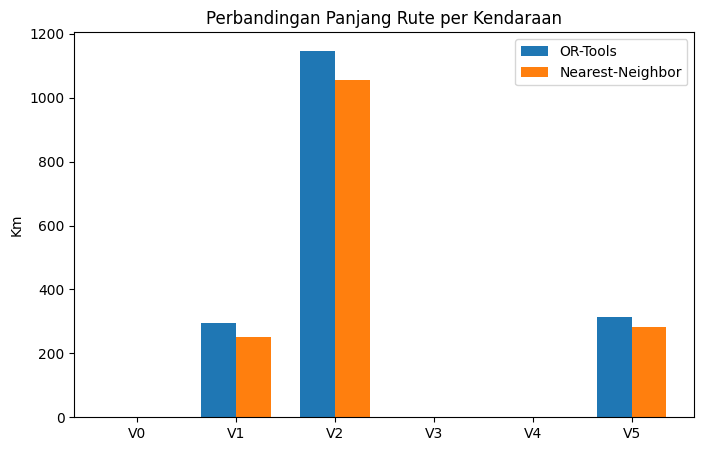

In [8]:
# =========================================================
# Sprint 1: Visualisasi & Analisis Dasar Rute Pengiriman
# - Peta interaktif Folium per kendaraan
# - KPI ringkas (jarak, stops, load factor, omzet, rating)
# - Pembanding dengan baseline Nearest-Neighbor (naif)
# =========================================================

!pip -q install folium

import pandas as pd
import numpy as np
import folium
from folium import plugins
import os, math
import matplotlib.pyplot as plt

# --------------------
# PARAMETER
# --------------------
ASSIGN_PATH = "data/route_plan/route_assignments.csv"
SUMMARY_PATH = "data/route_plan/route_summary.csv"
DATAMART_PATH = "data/olist_datamart_clean.csv"
GEO_PATH = "data/olist/olist_geolocation_dataset.csv"

VEHICLE_CAPACITY = 30   # untuk hitung load factor
MAP_OUT = "data/route_plan/route_map.html"

# --------------------
# LOAD DATA
# --------------------
assign_df = pd.read_csv(ASSIGN_PATH)
summary_df = pd.read_csv(SUMMARY_PATH)
datamart = pd.read_csv(DATAMART_PATH, low_memory=False)
geo = pd.read_csv(GEO_PATH, low_memory=False)

# koordinat rata-rata per zip
zip_latlng = (geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat","geolocation_lng"]]
                .mean()
                .rename(columns={"geolocation_lat":"lat","geolocation_lng":"lng"}))

# --------------------
# Siapkan data order (koordinat, kota, state, nilai)
# --------------------
need_cols = ["order_id","customer_zip_code_prefix","customer_city","customer_state","total_price","review_score_mean"]
order_info = datamart[need_cols].copy()

# join koordinat pelanggan via zip prefix
order_info = order_info.merge(zip_latlng, left_on="customer_zip_code_prefix", right_index=True, how="left")

# gabungkan ke assignment (agar setiap stop punya lat/lng & info bisnis)
assign = assign_df.merge(order_info, on="order_id", how="left")

# ambil depot dari baris "DEPOT" (node=0). Kita estimasi centroid bila perlu.
depot_rows = assign[assign["stop"]=="DEPOT"]
if depot_rows.empty:
    # fallback: centroid dari semua titik
    depot_lat = assign["lat"].mean()
    depot_lng = assign["lng"].mean()
else:
    # gunakan posisi depot pertama yang muncul (map butuh 1 koordinat pusat)
    # jika ingin lebih presisi, Anda bisa menyimpan lat/lng depot saat routing
    depot_lat = assign["lat"].mean()   # centroid pelanggan,
    depot_lng = assign["lng"].mean()   # agar map tidak kosong jika DEPOT tak punya lat/lng

# --------------------
# Fungsi util jarak haversine
# --------------------
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = (math.sin(dphi/2)**2 +
         math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2)
    return 2*R*math.asin(math.sqrt(a))

# --------------------
# KPI Ringkas (gabungkan summary + metrik bisnis)
# --------------------
kpi = summary_df.copy()
# stops & jarak sudah ada; tambahkan omzet & rating rata-rata
# hitung per vehicle berdasarkan assignment
biz = (assign[assign["stop"]!="DEPOT"]
       .groupby("vehicle")
       .agg(orders=("order_id","count"),
            revenue=("total_price","sum"),
            avg_review=("review_score_mean","mean"))
       .reset_index())
kpi = kpi.merge(biz, on="vehicle", how="left")
kpi["load_factor"] = (kpi["stops"] / VEHICLE_CAPACITY).round(3)
kpi.fillna({"revenue":0.0,"avg_review":0.0}, inplace=True)

print("=== KPI per Kendaraan ===")
display(kpi)

print("\nTotal distance (km):", kpi["route_distance_km"].sum().round(2))
print("Average distance per route (km):", kpi["route_distance_km"].mean().round(2))
print("Total stops:", int(kpi["stops"].sum()))
print("Total revenue:", round(kpi["revenue"].sum(), 2))

# --------------------
# PETA INTERAKTIF FOLIUM
# --------------------
m = folium.Map(location=[depot_lat, depot_lng], zoom_start=5, control_scale=True)
plugins.Fullscreen().add_to(m)

# palet warna sederhana untuk membedakan kendaraan
colors = ["red","blue","green","purple","orange","darkred","lightred","beige",
          "darkblue","darkgreen","cadetblue","darkpurple","white","pink","lightblue",
          "lightgreen","gray","black","lightgray"]
def color_for(v):
    return colors[v % len(colors)]

# plot marker depot (titik awal/akhir tidak tersimpan lat/lng spesifik; gunakan centroid)
folium.Marker(
    location=[depot_lat, depot_lng],
    tooltip="DEPOT",
    icon=folium.Icon(color="black", icon="home", prefix="fa")
).add_to(m)

# untuk setiap kendaraan, gambar polyline sesuai urutan sequence
for v, route in assign.groupby("vehicle", sort=True):
    # ambil urutan stop non-DEPOT
    r = route[route["stop"]!="DEPOT"].sort_values("sequence")
    # titik polyline (depot -> customers -> depot (opsional))
    pts = [[depot_lat, depot_lng]] + r[["lat","lng"]].dropna().values.tolist() + [[depot_lat, depot_lng]]

    # garis rute
    folium.PolyLine(pts, weight=3, opacity=0.8, color=color_for(v), tooltip=f"Vehicle {v}").add_to(m)

    # marker customers
    for _, row in r.iterrows():
        if pd.isna(row["lat"]) or pd.isna(row["lng"]):
            continue
        popup = folium.Popup(html=f"""
            <b>Vehicle:</b> {int(v)}<br>
            <b>Seq:</b> {int(row['sequence'])}<br>
            <b>Order:</b> {row['order_id']}<br>
            <b>City:</b> {row.get('customer_city','')}, {row.get('customer_state','')}<br>
            <b>Value:</b> {round(row.get('total_price',0.0),2)}<br>
            <b>Review:</b> {round(row.get('review_score_mean',0.0),2)}
        """, max_width=300)
        folium.CircleMarker(
            location=[row["lat"], row["lng"]],
            radius=4,
            color=color_for(v),
            fill=True,
            fill_opacity=0.7,
            tooltip=f"V{v} • Seq {int(row['sequence'])} • {row['customer_city']}",
            popup=popup
        ).add_to(m)

# simpan peta
os.makedirs(os.path.dirname(MAP_OUT), exist_ok=True)
m.save(MAP_OUT)
print(f"\nPeta disimpan ke: {MAP_OUT}  (buka di panel file & klik untuk preview)")

# --------------------
# Baseline Nearest-Neighbor (NN) vs Hasil OR-Tools
# Perbandingan dilakukan untuk set titik yang sama pada tiap vehicle:
# - hitung panjang rute OR-Tools dari polyline yang diplot
# - hitung panjang rute NN dari depot, lalu selalu ke tetangga terdekat yang belum dikunjungi
# --------------------
def route_length_km(points):
    if len(points) < 2: return 0.0
    dist = 0.0
    for i in range(len(points)-1):
        dist += haversine_km(points[i][0], points[i][1], points[i+1][0], points[i+1][1])
    return dist

def nearest_neighbor_path(depot, pts):
    # depot: (lat,lng)
    # pts: list of (lat,lng)
    remaining = pts.copy()
    path = [depot]
    current = depot
    while remaining:
        # pilih titik terdekat
        nxt = min(remaining, key=lambda p: haversine_km(current[0], current[1], p[0], p[1]))
        path.append(nxt)
        remaining.remove(nxt)
        current = nxt
    path.append(depot)  # kembali ke depot
    return path

compare_rows = []
for v, route in assign.groupby("vehicle", sort=True):
    r = route[route["stop"]!="DEPOT"].sort_values("sequence")
    pts = r[["lat","lng"]].dropna().values.tolist()
    if len(pts) == 0:
        or_km = 0.0
        nn_km = 0.0
    else:
        # OR-Tools: depot -> pts -> depot (sesuai sequence pada map)
        or_poly = [[depot_lat, depot_lng]] + pts + [[depot_lat, depot_lng]]
        or_km = route_length_km(or_poly)
        # Nearest Neighbor:
        nn_poly = nearest_neighbor_path((depot_lat, depot_lng), pts.copy())
        nn_km = route_length_km(nn_poly)
    compare_rows.append({"vehicle": v, "or_tools_km": or_km, "nearest_neighbor_km": nn_km})

cmp_df = pd.DataFrame(compare_rows)
cmp_df["improvement_km"] = (cmp_df["nearest_neighbor_km"] - cmp_df["or_tools_km"]).round(2)
cmp_df["improvement_%"] = (100*(cmp_df["nearest_neighbor_km"] - cmp_df["or_tools_km"]) / cmp_df["nearest_neighbor_km"]).replace([np.inf, -np.inf], np.nan).round(2)

print("\n=== Perbandingan Panjang Rute: OR-Tools vs Nearest-Neighbor ===")
display(cmp_df)

# Visualisasi bar
plt.figure(figsize=(8,5))
idx = np.arange(len(cmp_df))
width = 0.35
plt.bar(idx - width/2, cmp_df["or_tools_km"], width, label="OR-Tools")
plt.bar(idx + width/2, cmp_df["nearest_neighbor_km"], width, label="Nearest-Neighbor")
plt.xticks(idx, [f"V{int(v)}" for v in cmp_df["vehicle"]])
plt.ylabel("Km")
plt.title("Perbandingan Panjang Rute per Kendaraan")
plt.legend()
plt.show()


=== KPI Bisnis per Kendaraan ===


,vehicle,orders,revenue,avg_review,states,top_city,route_distance_km,stops,load_factor
0,1,26,1789.0,4.08,SP,sao paulo,129.301,26,0.867
1,2,30,1709.9,3.60,"MG, RJ, SP",rio de janeiro,973.032,30,1.000
2,5,12,837.0,4.25,SP,sao paulo,143.829,12,0.400



Saved: data/route_plan/route_business_summary.csv


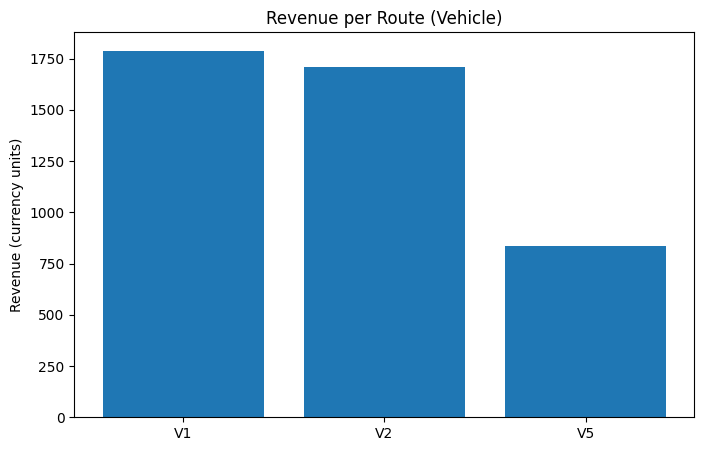

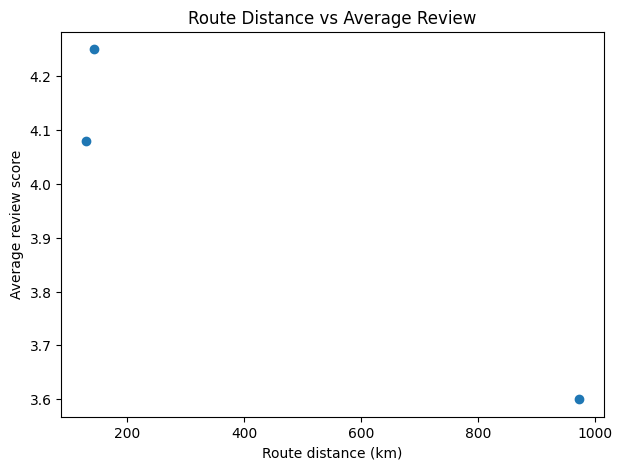

/tmp/ipython-input-290783996.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(veh_data, labels=veh_labels, showmeans=True)


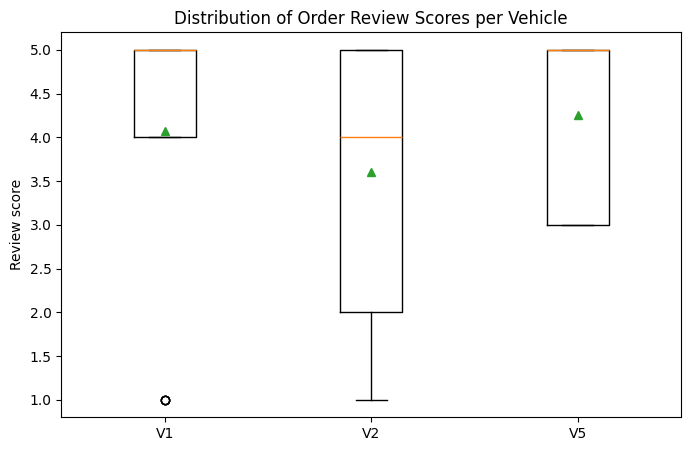

Saved: data/route_plan/route_category_mix.csv


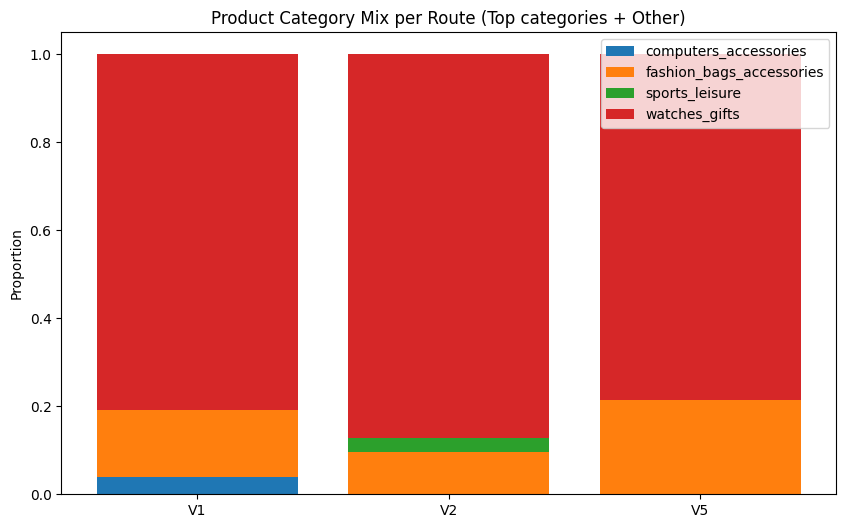


=== Quick Insights ===
- Revenue tertinggi: Vehicle V1
- Rute terpendek: Vehicle V1
- Korelasi jarak vs rating (kasar): -0.964


In [9]:
# ============================================================
# Sprint 2 – Integrasi Data Bisnis untuk Optimasi Rute Olist
# - Merge rute dengan datamart: omzet, rating, lokasi
# - KPI bisnis per kendaraan
# - Visualisasi (matplotlib): omzet/rute, jarak vs rating, boxplot rating
# - Komposisi kategori produk per rute (stacked bar)
# - Ekspor CSV ringkasan
# ============================================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# -----------------------
# Paths
# -----------------------
ASSIGN_PATH   = "data/route_plan/route_assignments.csv"
SUMMARY_PATH  = "data/route_plan/route_summary.csv"
DATAMART_PATH = "data/olist_datamart_clean.csv"
ORDER_ITEMS   = "data/olist/olist_order_items_dataset.csv"
PRODUCTS_PATH = "data/olist/olist_products_dataset.csv"
CAT_TR_PATH   = "data/olist/product_category_name_translation.csv"

OUT_DIR = "data/route_plan"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# Load
# -----------------------
assign_df = pd.read_csv(ASSIGN_PATH)
summary_df = pd.read_csv(SUMMARY_PATH)
datamart = pd.read_csv(DATAMART_PATH, low_memory=False)

# -----------------------
# Merge assignments ↔ datamart (order-level info)
# -----------------------
biz_cols = ["order_id","total_price","review_score_mean","customer_city","customer_state","main_product_category"]
assign_biz = assign_df.merge(datamart[biz_cols], on="order_id", how="left")

# Hanya stop pelanggan (exclude depot)
assign_biz_cust = assign_biz[assign_biz["stop"]!="DEPOT"].copy()

# -----------------------
# KPI bisnis per kendaraan (gabungkan summary)
# -----------------------
kpi = (
    assign_biz_cust
    .groupby("vehicle")
    .agg(
        orders=("order_id","count"),
        revenue=("total_price","sum"),
        avg_review=("review_score_mean","mean"),
        states=("customer_state", lambda s: ", ".join(sorted(pd.Series(s.dropna().unique())))),
        top_city=("customer_city", lambda s: s.value_counts().index[0] if s.notna().any() else "Unknown")
    )
    .reset_index()
)

# gabung jarak rute dari summary
kpi = kpi.merge(summary_df[["vehicle","route_distance_km","stops"]], on="vehicle", how="left")
kpi["revenue"] = kpi["revenue"].fillna(0).round(2)
kpi["avg_review"] = kpi["avg_review"].fillna(0).round(2)

# kapasitas opsional untuk load factor -> isi manual kalau ingin
VEHICLE_CAPACITY = 30
kpi["load_factor"] = (kpi["stops"] / VEHICLE_CAPACITY).round(3)

print("=== KPI Bisnis per Kendaraan ===")
display(kpi)

# Simpan KPI
kpi_out = os.path.join(OUT_DIR, "route_business_summary.csv")
kpi.to_csv(kpi_out, index=False)
print(f"\nSaved: {kpi_out}")

# -----------------------
# Visualisasi 1: Omzet per rute (bar)
# -----------------------
plt.figure(figsize=(8,5))
x = np.arange(len(kpi))
plt.bar(x, kpi["revenue"])
plt.xticks(x, [f"V{int(v)}" for v in kpi["vehicle"]])
plt.ylabel("Revenue (currency units)")
plt.title("Revenue per Route (Vehicle)")
plt.show()

# -----------------------
# Visualisasi 2: Scatter jarak vs rating
# -----------------------
plt.figure(figsize=(7,5))
plt.scatter(kpi["route_distance_km"], kpi["avg_review"])
plt.xlabel("Route distance (km)")
plt.ylabel("Average review score")
plt.title("Route Distance vs Average Review")
plt.show()

# -----------------------
# Visualisasi 3: Boxplot rating per vehicle (berbasis order)
# -----------------------
ratings_per_vehicle = (
    assign_biz_cust[["vehicle","review_score_mean"]]
    .dropna()
    .groupby("vehicle")["review_score_mean"]
    .apply(list)
    .to_dict()
)
veh_labels = [f"V{int(v)}" for v in sorted(ratings_per_vehicle.keys())]
veh_data = [ratings_per_vehicle[v] for v in sorted(ratings_per_vehicle.keys())]

if len(veh_data) > 0:
    plt.figure(figsize=(8,5))
    plt.boxplot(veh_data, labels=veh_labels, showmeans=True)
    plt.ylabel("Review score")
    plt.title("Distribution of Order Review Scores per Vehicle")
    plt.show()
else:
    print("\n[INFO] Tidak ada data rating yang cukup untuk boxplot.")

# ============================================================
# Komposisi kategori produk per rute (stacked bar)
# ============================================================

# Kita akan turunkan kategori dari item-level agar komposisinya akurat.
order_items = pd.read_csv(ORDER_ITEMS, low_memory=False, usecols=["order_id","product_id"])
products = pd.read_csv(PRODUCTS_PATH, low_memory=False, usecols=["product_id","product_category_name"])
cat_tr = pd.read_csv(CAT_TR_PATH, low_memory=False)
products = products.merge(cat_tr, how="left", on="product_category_name")
products["product_category"] = products["product_category_name_english"].fillna(products["product_category_name"])

# map order_id -> product_category (banyak baris per order)
oi_cat = order_items.merge(products[["product_id","product_category"]], on="product_id", how="left")

# join ke assignment untuk tahu vehiclenya
assign_items = assign_df[assign_df["stop"]!="DEPOT"][["vehicle","order_id"]].merge(oi_cat, on="order_id", how="left")

# hitung jumlah item per kategori per vehicle
cat_counts = (
    assign_items
    .groupby(["vehicle","product_category"])
    .size()
    .reset_index(name="count")
)

# ambil top K kategori secara global agar grafik tidak terlalu ramai
TOP_K = 8
top_global = (
    cat_counts.groupby("product_category")["count"].sum()
    .sort_values(ascending=False).head(TOP_K).index.tolist()
)

# agregasi kategori selain TOP_K menjadi "Other"
cat_counts["category_group"] = np.where(cat_counts["product_category"].isin(top_global),
                                        cat_counts["product_category"], "Other")

cat_mix = (
    cat_counts
    .groupby(["vehicle","category_group"])["count"].sum()
    .reset_index()
    .pivot(index="vehicle", columns="category_group", values="count")
    .fillna(0)
    .sort_index()
)

# simpan CSV komposisi kategori
cat_mix_out = os.path.join(OUT_DIR, "route_category_mix.csv")
cat_mix.to_csv(cat_mix_out)
print(f"Saved: {cat_mix_out}")

# Normalisasi menjadi proporsi
cat_mix_prop = cat_mix.div(cat_mix.sum(axis=1), axis=0).fillna(0)

# -----------------------
# Visualisasi 4: Stacked bar komposisi kategori per vehicle
# -----------------------
plt.figure(figsize=(10,6))
bottom = np.zeros(len(cat_mix_prop))
x = np.arange(len(cat_mix_prop.index))
labels = [f"V{int(v)}" for v in cat_mix_prop.index]

for col in cat_mix_prop.columns:
    plt.bar(x, cat_mix_prop[col].values, bottom=bottom, label=str(col))
    bottom += cat_mix_prop[col].values

plt.xticks(x, labels)
plt.ylabel("Proportion")
plt.title("Product Category Mix per Route (Top categories + Other)")
plt.legend(loc="best")
plt.show()

# ============================================================
# Insight cepat (printed)
# ============================================================
print("\n=== Quick Insights ===")
if not kpi.empty:
    v_best_rev = kpi.loc[kpi["revenue"].idxmax(), "vehicle"]
    print(f"- Revenue tertinggi: Vehicle V{int(v_best_rev)}")
    v_shortest = kpi.loc[kpi["route_distance_km"].idxmin(), "vehicle"]
    print(f"- Rute terpendek: Vehicle V{int(v_shortest)}")
    corr = np.corrcoef(kpi["route_distance_km"].fillna(0), kpi["avg_review"].fillna(0))[0,1]
    print(f"- Korelasi jarak vs rating (kasar): {round(float(corr),3)}")
else:
    print("- KPI kosong.")


In [10]:
# ===============================================================
# Sprint 3: VRPTW (Vehicle Routing Problem with Time Windows)
# ---------------------------------------------------------------
# - Kapasitas kendaraan (CVRP) + Time Windows (jam kerja)
# - Service time per stop
# - Default: semua pelanggan 09:00–18:00
# - Optional: prioritas top-20% nilai order -> 09:00–12:00
# - Output CSV: assignments & summary (VRPTW)
# ===============================================================

!pip -q install ortools

import pandas as pd
import numpy as np
import os, math
from datetime import datetime, timedelta

# =======================
# 0) PARAMETER USER
# =======================
DATAMART_PATH = "data/olist_datamart_clean.csv"
GEO_PATH      = "data/olist/olist_geolocation_dataset.csv"
ORDER_ITEMS   = "data/olist/olist_order_items_dataset.csv"
SELLERS_PATH  = "data/olist/olist_sellers_dataset.csv"

SELLER_ID = None               # None -> auto pick seller tersibuk pada periode
DATE_FROM = "2018-07-01"
DATE_TO   = "2018-07-31"

VEHICLE_COUNT     = 4          # jumlah kendaraan (akan di-auto-scale jika kapasitas kurang)
VEHICLE_CAPACITY  = 30         # 1 paket per order
AVG_SPEED_KMPH    = 30.0       # kecepatan rata-rata (untuk konversi jarak -> menit)
SERVICE_MIN_PER_STOP = 10      # waktu servis di lokasi pelanggan (menit)

# Jam kerja (time window) default (jam lokal)
WORK_START = "09:00"
WORK_END   = "18:00"

# Prioritas: top-N% nilai order dapat window lebih ketat (mis. 09:00-12:00)
ENABLE_PRIORITY_WINDOWS = True
PRIORITY_PERCENTILE     = 0.80   # top-20% (>= 80th percentile)
PRIORITY_START = "09:00"
PRIORITY_END   = "12:00"

# Batas panjang rute (opsional), dalam km
MAX_ROUTE_KM = None

# =======================
# 1) LOAD DATA
# =======================
datamart = pd.read_csv(DATAMART_PATH, low_memory=False)
geo = pd.read_csv(GEO_PATH, low_memory=False)
order_items = pd.read_csv(ORDER_ITEMS, low_memory=False, usecols=["order_id","seller_id"])
sellers = pd.read_csv(SELLERS_PATH, low_memory=False)

# koordinat rata-rata per zip
zip_latlng = (geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat","geolocation_lng"]]
                .mean().rename(columns={"geolocation_lat":"lat","geolocation_lng":"lng"}))

# parse tanggal delivered
datamart["order_delivered_customer_date"] = pd.to_datetime(datamart["order_delivered_customer_date"], errors="coerce")

# filter delivered + date range
mask = (
    (datamart["order_status"]=="delivered") &
    (datamart["order_delivered_customer_date"].between(pd.to_datetime(DATE_FROM), pd.to_datetime(DATE_TO)))
)
df = datamart.loc[mask].copy()

# join seller_id
df = df.merge(order_items.drop_duplicates(), on="order_id", how="left")

# auto-pick seller jika None
if SELLER_ID is None:
    SELLER_ID = df["seller_id"].value_counts().index[0]
    print(f"[INFO] SELLER_ID tidak diisi. Menggunakan seller populer periode ini: {SELLER_ID}")

df = df[df["seller_id"]==SELLER_ID].copy()
if df.empty:
    raise ValueError("Tidak ada order untuk SELLER_ID & rentang tanggal tersebut.")

# 1 order = 1 paket
df["packages"] = 1

# =======================
# 2) KOORDINAT DEPOT & PELANGGAN
# =======================
# depot dari seller zip prefix
seller_row = sellers[sellers["seller_id"]==SELLER_ID]
if seller_row.empty:
    raise ValueError("SELLER_ID tidak ditemukan di sellers dataset.")
seller_zip = seller_row["seller_zip_code_prefix"].mode().iloc[0]

depot_latlng = zip_latlng.loc[seller_zip] if seller_zip in zip_latlng.index else None

# koordinat pelanggan dari zip prefix
df = df.merge(zip_latlng, left_on="customer_zip_code_prefix", right_index=True, how="left")
df = df.dropna(subset=["lat","lng"]).reset_index(drop=True)

if df.shape[0] < 3:
    raise ValueError("Titik pengantaran < 3 setelah filter. Perlu lebih banyak order.")

if (depot_latlng is None) or depot_latlng.isna().any():
    print("[WARN] Koordinat depot tidak ditemukan dari zip prefix. Pakai centroid pelanggan.")
    depot_latlng = pd.Series({"lat": df["lat"].mean(), "lng": df["lng"].mean()})

points = [(float(depot_latlng["lat"]), float(depot_latlng["lng"]))] \
       + list(zip(df["lat"].astype(float), df["lng"].astype(float)))

# =======================
# 3) DISTANCE & TIME MATRIX
# =======================
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = (math.sin(dphi/2)**2 +
         math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2)
    return 2*R*math.asin(math.sqrt(a))

n = len(points)
dist_matrix_km = [[0.0]*n for _ in range(n)]
for i in range(n):
    for j in range(n):
        if i==j:
            dist = 0.0
        else:
            dist = haversine_km(points[i][0], points[i][1], points[j][0], points[j][1])
        dist_matrix_km[i][j] = dist

# konversi ke menit (travel time), OR-Tools butuh integer
def km_to_minutes(km, speed_kmph=AVG_SPEED_KMPH):
    return int(round((km / speed_kmph) * 60.0))

time_matrix_min = [[km_to_minutes(d) for d in row] for row in dist_matrix_km]

# service time per node (menit); depot = 0
service_time = [0] + [SERVICE_MIN_PER_STOP]* (n-1)

# demand: depot=0
demands = [0] + df["packages"].astype(int).tolist()

# =======================
# 4) TIME WINDOWS
# =======================
def parse_hhmm(s):
    h, m = s.split(":")
    return int(h), int(m)

# horizon: 1 hari kerja (misal 8:00–20:00 agar cukup)
# kita pakai nol sebagai 00:00; jadikan semua window dalam menit dari 00:00
WSTART_H, WSTART_M = parse_hhmm(WORK_START)
WEND_H, WEND_M     = parse_hhmm(WORK_END)
DEFAULT_START = WSTART_H*60 + WSTART_M
DEFAULT_END   = WEND_H*60 + WEND_M

# Priority windows (lebih ketat) untuk top-20% revenue
tw_start = [DEFAULT_START] * n
tw_end   = [DEFAULT_END]   * n

if ENABLE_PRIORITY_WINDOWS:
    pcut = df["total_price"].quantile(PRIORITY_PERCENTILE)
    priority_mask = df["total_price"] >= pcut
    PSTART_H, PSTART_M = parse_hhmm(PRIORITY_START)
    PEND_H, PEND_M     = parse_hhmm(PRIORITY_END)
    PR_START = PSTART_H*60 + PSTART_M
    PR_END   = PEND_H*60 + PEND_M
    # node index 1..n-1 -> df index 0..m-1
    for idx, is_prio in enumerate(priority_mask.tolist(), start=1):
        if is_prio:
            tw_start[idx] = PR_START
            tw_end[idx]   = PR_END

# depot window = jam kerja default
tw_start[0] = DEFAULT_START
tw_end[0]   = DEFAULT_END

# =========================================================
# 5) SOLVE VRPTW (robust): soft upper bound + drops + fallback
# =========================================================
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import math

def try_solve_vrptw(
    VEHICLE_COUNT, VEHICLE_CAPACITY,
    time_matrix_min, dist_matrix_km,
    demands, service_time, tw_start, tw_end,
    allow_drops=True,
    drop_penalty_min=60*8,         # penalti drop ~8 jam
    late_penalty_per_min=5,        # penalti keterlambatan per menit
    time_limit_s=180,              # waktu solver
    max_route_km=None
):
    n = len(time_matrix_min)
    manager = pywrapcp.RoutingIndexManager(n, VEHICLE_COUNT, 0)  # depot=0
    routing = pywrapcp.RoutingModel(manager)

    # Transit = TRAVEL TIME (menit)
    def travel_time_cb(from_index, to_index):
        i = manager.IndexToNode(from_index)
        j = manager.IndexToNode(to_index)
        return int(time_matrix_min[i][j])
    travel_time_cb_idx = routing.RegisterTransitCallback(travel_time_cb)
    routing.SetArcCostEvaluatorOfAllVehicles(travel_time_cb_idx)

    # Kapasitas
    def demand_cb(from_index):
        node = manager.IndexToNode(from_index)
        return int(demands[node])
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_cb)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,
        [VEHICLE_CAPACITY]*VEHICLE_COUNT,
        True,
        "Capacity"
    )

    # Time dimension: travel + service via SlackVar
    routing.AddDimension(
        travel_time_cb_idx,
        60*12,   # waiting allowance
        60*24,   # horizon
        False,
        "Time"
    )
    time_dim = routing.GetDimensionOrDie("Time")

    # Hard lower bound = start window; upper bound = HORIZON (biar tidak infeasible),
    # dan kita tambahkan SOFT UPPER BOUND dengan penalti keterlambatan.
    H = 60*24
    for node in range(n):
        idx = manager.NodeToIndex(node)
        lb = int(tw_start[node])
        ub = H
        time_dim.CumulVar(idx).SetRange(lb, ub)

    # Service time sebagai slack
    time_dim.SlackVar(manager.NodeToIndex(0)).SetValue(0)
    for node in range(1, n):
        time_dim.SlackVar(manager.NodeToIndex(node)).SetValue(int(service_time[node]))

    # Soft upper bound pada setiap node (termasuk depot)
    for node in range(n):
        idx = manager.NodeToIndex(node)
        time_dim.SetCumulVarSoftUpperBound(idx, int(tw_end[node]), int(late_penalty_per_min))

    # (Opsional) Batas jarak
    if max_route_km is not None:
        def dist_cb(from_index, to_index):
            i = manager.IndexToNode(from_index)
            j = manager.IndexToNode(to_index)
            return int(round(dist_matrix_km[i][j] * 1000))  # meters
        dist_cb_idx = routing.RegisterTransitCallback(dist_cb)
        routing.AddDimension(dist_cb_idx, 0, int(max_route_km*1000), True, "Distance")

    # Izinkan drop node dengan penalti besar (kecuali depot)
    if allow_drops:
        for node in range(1, n):
            routing.AddDisjunction([manager.NodeToIndex(node)], int(drop_penalty_min))

    # Finalizer agar waktu start/end kecil
    for v in range(VEHICLE_COUNT):
        routing.AddVariableMinimizedByFinalizer(time_dim.CumulVar(routing.Start(v)))
        routing.AddVariableMinimizedByFinalizer(time_dim.CumulVar(routing.End(v)))

    # Search params
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(int(time_limit_s))
    search_params.log_search = True

    solution = routing.SolveWithParameters(search_params)
    return manager, routing, time_dim, solution

# ---------- Auto-scale armada ----------
total_packages = int(df["packages"].sum())
min_vehicles = math.ceil(total_packages / VEHICLE_CAPACITY)
if VEHICLE_COUNT < min_vehicles:
    print(f"[AUTO] VEHICLE_COUNT naik {VEHICLE_COUNT} -> {min_vehicles} "
          f"(paket {total_packages}, kapasitas/veh {VEHICLE_CAPACITY})")
    VEHICLE_COUNT = min_vehicles

# ---------- ATUR fallback bertahap ----------
attempts = [
    {"label":"base",            "allow_drops":True,  "late_penalty_per_min":5,  "widen":0,  "priority_off":False, "speed_boost":1.0, "extra_vehicles":0},
    {"label":"widen+30",        "allow_drops":True,  "late_penalty_per_min":3,  "widen":30, "priority_off":False, "speed_boost":1.0, "extra_vehicles":0},
    {"label":"priority_off",    "allow_drops":True,  "late_penalty_per_min":3,  "widen":30, "priority_off":True,  "speed_boost":1.0, "extra_vehicles":0},
    {"label":"speed×1.3",       "allow_drops":True,  "late_penalty_per_min":2,  "widen":45, "priority_off":True,  "speed_boost":1.3, "extra_vehicles":0},
    {"label":"add_vehicles+1",  "allow_drops":True,  "late_penalty_per_min":2,  "widen":60, "priority_off":True,  "speed_boost":1.3, "extra_vehicles":1},
    {"label":"add_vehicles+2",  "allow_drops":True,  "late_penalty_per_min":1,  "widen":90, "priority_off":True,  "speed_boost":1.5, "extra_vehicles":2},
]

# Salin time matrix awal agar bisa “speed boost” tanpa merusak aslinya
base_time_matrix = [row[:] for row in time_matrix_min]
base_tw_start = tw_start[:]
base_tw_end   = tw_end[:]

solution = None
for att in attempts:
    print(f"\n[TRY] {att['label']}")
    # 1) speed boost
    time_matrix_try = [[int(round(t/att["speed_boost"])) for t in row] for row in base_time_matrix]

    # 2) window relax
    tw_start_try = base_tw_start[:]
    tw_end_try   = [min(60*24, e + att["widen"]) for e in base_tw_end]  # tambah kelonggaran di sisi atas

    # 3) priority off (jika sebelumnya kamu pakai PRIORITY window)
    if att["priority_off"] and ENABLE_PRIORITY_WINDOWS:
        # reset semua ke default work window
        for i in range(1, len(tw_start_try)):
            tw_start_try[i] = base_tw_start[0]  # depot start = default start
            tw_end_try[i]   = base_tw_end[0]

    # 4) tambah kendaraan
    veh_try = VEHICLE_COUNT + att["extra_vehicles"]

    manager, routing, time_dim, sol = try_solve_vrptw(
        VEHICLE_COUNT=veh_try,
        VEHICLE_CAPACITY=VEHICLE_CAPACITY,
        time_matrix_min=time_matrix_try,
        dist_matrix_km=dist_matrix_km,
        demands=demands,
        service_time=service_time,
        tw_start=tw_start_try,
        tw_end=tw_end_try,
        allow_drops=att["allow_drops"],
        drop_penalty_min=60*8,
        late_penalty_per_min=att["late_penalty_per_min"],
        time_limit_s=240,
        max_route_km=MAX_ROUTE_KM
    )
    if sol:
        print(f"[OK] Solusi ditemukan pada attempt: {att['label']} (vehicles={veh_try})")
        solution = sol
        time_matrix_min = time_matrix_try   # pakai versi terakhir yang feasible
        tw_start = tw_start_try
        tw_end   = tw_end_try
        VEHICLE_COUNT = veh_try
        break
    else:
        print("[INFO] Belum feasible, lanjut ke attempt berikutnya...")

if not solution:
    raise RuntimeError("VRPTW masih gagal meski sudah dilonggarkan. Coba persempit rentang tanggal atau subset wilayah (customer_state).")



# =======================
# 6) EXTRACT ROUTES
# =======================
def get_vrptw_routes(routing, manager, solution):
    routes = []
    for v in range(VEHICLE_COUNT):
        index = routing.Start(v)
        nodes = []
        times = []
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            t = solution.Value(time_dim.CumulVar(index))
            nodes.append(node)
            times.append(t)
            index = solution.Value(routing.NextVar(index))
        # append end
        node = manager.IndexToNode(index)
        t = solution.Value(time_dim.CumulVar(index))
        nodes.append(node); times.append(t)
        routes.append({"vehicle": v, "nodes": nodes, "times": times})
    return routes

routes = get_vrptw_routes(routing, manager, solution)

# =======================
# 7) BANGUN OUTPUT DATAFRAME
# =======================
assign_rows = []
total_km = 0.0

def minutes_to_hhmm(m):
    h = int(m // 60)
    mm = int(m % 60)
    return f"{h:02d}:{mm:02d}"

for r in routes:
    seq = 0
    dist_r_km = 0.0
    for idx in range(len(r["nodes"]) - 1):
        node = r["nodes"][idx]
        next_node = r["nodes"][idx+1]
        arrive_min = r["times"][idx]
        leave_min  = r["times"][idx] + (service_time[node] if node != 0 else 0)

        if node == 0:
            order_id = None
            stop = "DEPOT"
            city_state = ""
        else:
            row = df.iloc[node - 1]
            order_id = row["order_id"]
            stop = f"{row['customer_city']}, {row['customer_state']}"
            city_state = stop

        assign_rows.append({
            "vehicle": r["vehicle"],
            "sequence": seq,
            "node": node,
            "stop": stop,
            "order_id": order_id,
            "arrival_time": minutes_to_hhmm(arrive_min),
            "depart_time": minutes_to_hhmm(leave_min),
            "time_window": f"{minutes_to_hhmm(tw_start[node])}-{minutes_to_hhmm(tw_end[node])}"
        })
        # distance accumulation
        dist_r_km += dist_matrix_km[node][next_node]
        seq += 1

    total_km += dist_r_km

assign_df = pd.DataFrame(assign_rows).sort_values(["vehicle","sequence"]).reset_index(drop=True)

summary_rows = []
for r in routes:
    # hitung jarak per kendaraan
    dist_r_km = 0.0
    for i in range(len(r["nodes"]) - 1):
        a, b = r["nodes"][i], r["nodes"][i+1]
        dist_r_km += dist_matrix_km[a][b]
    # stops (exclude depot)
    stops = sum(1 for n in r["nodes"] if n != 0)
    summary_rows.append({
        "vehicle": r["vehicle"],
        "stops": stops,
        "route_distance_km": round(dist_r_km, 3),
        "start_time": minutes_to_hhmm(r["times"][0]),
        "end_time": minutes_to_hhmm(r["times"][-1]),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("vehicle").reset_index(drop=True)

# =======================
# 8) SAVE OUTPUT
# =======================
os.makedirs("data/route_plan", exist_ok=True)
assign_out = "data/route_plan/route_assignments_vrptw.csv"
summary_out = "data/route_plan/route_summary_vrptw.csv"

assign_df.to_csv(assign_out, index=False)
summary_df.to_csv(summary_out, index=False)

print("\n=== VRPTW Selesai ===")
print(f"- Assignments: {assign_out}")
print(f"- Summary    : {summary_out}")
print(summary_df.head())


[INFO] SELLER_ID tidak diisi. Menggunakan seller populer periode ini: 6560211a19b47992c3666cc44a7e94c0
[AUTO] VEHICLE_COUNT naik 4 -> 6 (paket 154, kapasitas/veh 30)

[TRY] base
[OK] Solusi ditemukan pada attempt: base (vehicles=6)

=== VRPTW Selesai ===
- Assignments: data/route_plan/route_assignments_vrptw.csv
- Summary    : data/route_plan/route_summary_vrptw.csv
   vehicle  stops  route_distance_km start_time end_time
0        0     10            144.133      09:00    15:28
1        1      6            471.993      00:00    22:39
2        2      5            182.496      00:00    15:22
3        3     12            265.582      00:00    18:32
4        4     18             86.009      00:00    14:33


In [11]:
# ===============================================================
# Sprint 4: Multi-Depot Vehicle Routing (MDVRP) for Olist
# ---------------------------------------------------------------
# - Pilih K depot (seller_zip_code_prefix ter-ramai di periode)
# - Kendaraan start & end di depotnya masing-masing
# - CVRP (kapasitas), opsi batas jarak (km), opsi drop node (penalti)
# - Output CSV: assignments & summary (multi-depot)
# ===============================================================

!pip -q install ortools

import pandas as pd
import numpy as np
import os, math
from datetime import datetime

# ----------------------
# PARAMETER
# ----------------------
DATAMART_PATH = "data/olist_datamart_clean.csv"
GEO_PATH      = "data/olist/olist_geolocation_dataset.csv"
ORDER_ITEMS   = "data/olist/olist_order_items_dataset.csv"
SELLERS_PATH  = "data/olist/olist_sellers_dataset.csv"

DATE_FROM = "2018-07-01"
DATE_TO   = "2018-07-31"

# Pilih jumlah depot (otomatis top-K seller_zip_code_prefix ter-ramai di periode)
K_DEPOTS = 3

# Kendaraan per depot:
VEHICLES_PER_DEPOT = 3          # bisa int (sama untuk semua depot)
VEHICLE_CAPACITY   = 30         # 1 paket per order
MAX_ROUTE_KM       = None       # mis. 150.0 untuk batasi jarak rute (km) per kendaraan; atau None

# Opsi robustness
ALLOW_DROPS           = True    # boleh “buang” titik (outlier) dengan penalti
DROP_PENALTY_METERS   = 80_000  # ~80 km setara penalti drop
SEARCH_TIME_LIMIT_SEC = 180     # batas waktu solver

# ----------------------
# LOAD & FILTER DATA
# ----------------------
datamart = pd.read_csv(DATAMART_PATH, low_memory=False)
geo      = pd.read_csv(GEO_PATH, low_memory=False)
order_items = pd.read_csv(ORDER_ITEMS, low_memory=False, usecols=["order_id","seller_id"])
sellers     = pd.read_csv(SELLERS_PATH, low_memory=False)

# mapping zip -> lat,lng (rata-rata)
zip_latlng = (geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat","geolocation_lng"]]
                .mean().rename(columns={"geolocation_lat":"lat","geolocation_lng":"lng"}))

# filter delivered & tanggal
datamart["order_delivered_customer_date"] = pd.to_datetime(datamart["order_delivered_customer_date"], errors="coerce")
mask = (
    (datamart["order_status"]=="delivered") &
    (datamart["order_delivered_customer_date"].between(pd.to_datetime(DATE_FROM), pd.to_datetime(DATE_TO)))
)
orders = datamart.loc[mask, ["order_id","customer_zip_code_prefix","customer_city","customer_state","total_price"]].copy()

if orders.empty:
    raise ValueError("Tidak ada order pada rentang tanggal ini.")

# join seller_id per order (agar tahu depot mana yang relevan di periode tsb)
orders = orders.merge(order_items.drop_duplicates(), on="order_id", how="left")

# pilih top-K depot (seller_zip_code_prefix) berdasarkan frekuensi seller di periode
seller_zip = sellers[["seller_id","seller_zip_code_prefix"]].dropna()
orders = orders.merge(seller_zip, on="seller_id", how="left", validate="m:1")

top_seller_ids = (orders["seller_id"].value_counts().head(max(K_DEPOTS,1)).index.tolist())
dep_tbl = sellers[sellers["seller_id"].isin(top_seller_ids)][["seller_id","seller_zip_code_prefix"]].drop_duplicates()

# hitung koordinat depot dari zip prefix
dep_tbl = dep_tbl.merge(zip_latlng, left_on="seller_zip_code_prefix", right_index=True, how="left")
dep_tbl = dep_tbl.dropna(subset=["lat","lng"]).reset_index(drop=True)

if dep_tbl.empty:
    raise ValueError("Tidak berhasil menentukan koordinat depot dari seller zip.")

# jika jumlah depot aktual < K_DEPOTS, pakai yang tersedia
dep_tbl = dep_tbl.head(K_DEPOTS)
D = len(dep_tbl)  # jumlah depot aktual

print(f"[INFO] Depots terpilih: {D}")
print(dep_tbl[["seller_id","seller_zip_code_prefix","lat","lng"]])

# koordinat pelanggan (via zip)
orders = orders.merge(zip_latlng, left_on="customer_zip_code_prefix", right_index=True, how="left")
orders = orders.dropna(subset=["lat","lng"]).reset_index(drop=True)

# 1 order = 1 paket
orders["packages"] = 1

# ----------------------
# SUSUN NODE: depots lalu customers
# ----------------------
# depots: index 0..D-1
dep_points = list(zip(dep_tbl["lat"].astype(float), dep_tbl["lng"].astype(float)))
# customers: index D..D+N-1
cust_points = list(zip(orders["lat"].astype(float), orders["lng"].astype(float)))

points = dep_points + cust_points
N = len(cust_points)
num_nodes = len(points)

# ----------------------
# DISTANCE MATRIX (KM)
# ----------------------
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = (math.sin(dphi/2)**2 +
         math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2)
    return 2*R*math.asin(math.sqrt(a))

dist_matrix_km = [[0.0]*num_nodes for _ in range(num_nodes)]
for i in range(num_nodes):
    for j in range(num_nodes):
        if i == j:
            dist_matrix_km[i][j] = 0.0
        else:
            dist_matrix_km[i][j] = haversine_km(points[i][0], points[i][1], points[j][0], points[j][1])

# demands: depot 0..D-1 = 0; customers D.. = 1
demands = [0]*D + orders["packages"].astype(int).tolist()

# ----------------------
# VEHICLES & START/END
# ----------------------
# kendaraan per depot (array panjang D)
if isinstance(VEHICLES_PER_DEPOT, int):
    vehicles_per_depot = [VEHICLES_PER_DEPOT]*D
else:
    assert len(VEHICLES_PER_DEPOT)==D, "VEHICLES_PER_DEPOT harus int atau list dengan panjang = jumlah depot."
    vehicles_per_depot = list(VEHICLES_PER_DEPOT)

# Auto-scale agar kapasitas total >= total packages
total_packages = int(sum(demands))
total_capacity = sum(v * VEHICLE_CAPACITY for v in vehicles_per_depot)
if total_capacity < total_packages:
    need = math.ceil((total_packages - total_capacity) / VEHICLE_CAPACITY)
    print(f"[AUTO] Tambah kendaraan total {need} agar kapasitas cukup.")
    # distribusi ekstra secara merata ke depot
    for k in range(need):
        vehicles_per_depot[k % D] += 1

num_vehicles = sum(vehicles_per_depot)

# Bangun arrays starts/ends untuk OR-Tools (index node untuk tiap kendaraan)
starts = []
ends   = []
for d_idx in range(D):
    depot_node_index = d_idx  # depot di awal nodes
    for _ in range(vehicles_per_depot[d_idx]):
        starts.append(depot_node_index)
        ends.append(depot_node_index)

# ----------------------
# SOLVE (OR-Tools)
# ----------------------
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

manager = pywrapcp.RoutingIndexManager(num_nodes, num_vehicles, starts, ends)
routing = pywrapcp.RoutingModel(manager)

# Cost = distance (meter, integer)
def dist_cb(from_index, to_index):
    i = manager.IndexToNode(from_index)
    j = manager.IndexToNode(to_index)
    return int(round(dist_matrix_km[i][j] * 1000))

transit_cb_idx = routing.RegisterTransitCallback(dist_cb)
routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

# Kapasitas
def demand_cb(from_index):
    node = manager.IndexToNode(from_index)
    return int(demands[node])
demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_cb)
routing.AddDimensionWithVehicleCapacity(
    demand_cb_idx,
    0,
    [VEHICLE_CAPACITY]*num_vehicles,
    True,
    "Capacity"
)

# (Opsional) Batas jarak per rute
if MAX_ROUTE_KM is not None:
    routing.AddDimension(
        transit_cb_idx,
        0,
        int(MAX_ROUTE_KM*1000),
        True,
        "Distance"
    )

# Izinkan drop pelanggan (bukan depot) dengan penalti
if ALLOW_DROPS:
    for node in range(D, num_nodes):  # hanya customers
        routing.AddDisjunction([manager.NodeToIndex(node)], DROP_PENALTY_METERS)

# Search params
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
search_params.time_limit.FromSeconds(SEARCH_TIME_LIMIT_SEC)
search_params.log_search = True

solution = routing.SolveWithParameters(search_params)
if not solution:
    raise RuntimeError("MDVRP gagal menemukan solusi. Coba tambah kendaraan/kapasitas, longgarkan MAX_ROUTE_KM, atau izinkan drop.")

# ----------------------
# EXTRACT ROUTES
# ----------------------
routes = []
for v in range(num_vehicles):
    index = routing.Start(v)
    nodes = []
    distance_m = 0
    while not routing.IsEnd(index):
        node = manager.IndexToNode(index)
        nodes.append(node)
        prev = index
        index = solution.Value(routing.NextVar(index))
        distance_m += routing.GetArcCostForVehicle(prev, index, v)
    nodes.append(manager.IndexToNode(index))  # end (depot)
    routes.append({"vehicle": v, "nodes": nodes, "distance_km": distance_m/1000.0})

# mapping vehicle -> depot id (0..D-1)
veh2depot = []
vi = 0
for d_idx, nveh in enumerate(vehicles_per_depot):
    for _ in range(nveh):
        veh2depot.append(d_idx)
        vi += 1

# Build assignment DF
rows = []
for r in routes:
    v = r["vehicle"]
    seq = 0
    for node in r["nodes"]:
        if node < D:
            stop = f"DEPOT_{node}"
            order_id = None
            city = state = ""
            lat, lng = dep_points[node]
        else:
            idx = node - D
            stop = f"{orders.iloc[idx]['customer_city']}, {orders.iloc[idx]['customer_state']}"
            order_id = orders.iloc[idx]["order_id"]
            city = orders.iloc[idx]["customer_city"]
            state = orders.iloc[idx]["customer_state"]
            lat, lng = cust_points[idx]
        rows.append({
            "vehicle": v,
            "depot_id": veh2depot[v],
            "sequence": seq,
            "node": node,
            "stop": stop,
            "order_id": order_id,
            "customer_city": city,
            "customer_state": state,
            "lat": lat,
            "lng": lng
        })
        seq += 1

assign_df = pd.DataFrame(rows).sort_values(["vehicle","sequence"]).reset_index(drop=True)

# Ringkasan per kendaraan
summary = (assign_df.assign(is_customer=assign_df["order_id"].notna())
           .groupby("vehicle")
           .agg(depot_id=("depot_id","first"),
                stops=("is_customer","sum"))
           .reset_index())

summary["route_distance_km"] = [round(r["distance_km"],3) for r in routes]

# Info depot
summary["depot_zip"] = summary["depot_id"].map(dict(enumerate(dep_tbl["seller_zip_code_prefix"].tolist())))
summary["depot_lat"] = summary["depot_id"].map(dict(enumerate(dep_tbl["lat"].tolist())))
summary["depot_lng"] = summary["depot_id"].map(dict(enumerate(dep_tbl["lng"].tolist())))

# ----------------------
# SAVE OUTPUT
# ----------------------
os.makedirs("data/route_plan", exist_ok=True)
assign_out = "data/route_plan/route_assignments_multi.csv"
summary_out = "data/route_plan/route_summary_multi.csv"
assign_df.to_csv(assign_out, index=False)
summary.to_csv(summary_out, index=False)

print("\n=== MDVRP Selesai ===")
print(f"- Assignments: {assign_out}")
print(f"- Summary    : {summary_out}")
print(summary.head())


[INFO] Depots terpilih: 3
                          seller_id  seller_zip_code_prefix        lat  \
0  6560211a19b47992c3666cc44a7e94c0                    5849 -23.652366   
1  4a3ca9315b744ce9f8e9374361493884                   14940 -21.757321   
2  1025f0e2d44d7041d6cf58b6550e0bfa                    3204 -23.595499   

         lng  
0 -46.755753  
1 -48.829744  
2 -46.559727  
[AUTO] Tambah kendaraan total 178 agar kapasitas cukup.

=== MDVRP Selesai ===
- Assignments: data/route_plan/route_assignments_multi.csv
- Summary    : data/route_plan/route_summary_multi.csv
   vehicle  depot_id  stops  route_distance_km  depot_zip  depot_lat  \
0        0         0     30           8965.312       5849 -23.652366   
1        1         0     30           5255.424       5849 -23.652366   
2        2         0     30           4524.167       5849 -23.652366   
3        3         0     30           4337.362       5849 -23.652366   
4        4         0     30           5284.034       5849 -23.65